In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [30]:
train_dataset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

Files already downloaded and verified


In [31]:
# Defining GAN hyperparameters
latent_dim = 100 # dimensionality of noise vector
lr = 0.0002
# Beta parameters for adam optimizer
beta1 = 0.5
beta2 = 0.999
num_epochs = 100

In [32]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128*8*8), # Fully connected layer to project the noise into higher dimensional feature space
            nn.ReLU(),
            nn.Unflatten(1,(128,8,8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128,momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64,momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64,3,kernel_size=3,padding=1),
            nn.Tanh()
        )

    def forward(self,z):
        img = self.model(z)
        return img

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.ZeroPad2d((0,1,0,1)),
            nn.BatchNorm2d(64,momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128,momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity    

In [34]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

Epoch [1/100]                        Batch 100/1563 Discriminator Loss: 0.4889 Generator Loss: 1.4781
Epoch [1/100]                        Batch 200/1563 Discriminator Loss: 0.6335 Generator Loss: 1.1797
Epoch [1/100]                        Batch 300/1563 Discriminator Loss: 0.4322 Generator Loss: 1.3247
Epoch [1/100]                        Batch 400/1563 Discriminator Loss: 0.4925 Generator Loss: 1.2190
Epoch [1/100]                        Batch 500/1563 Discriminator Loss: 0.7379 Generator Loss: 1.1415
Epoch [1/100]                        Batch 600/1563 Discriminator Loss: 0.7147 Generator Loss: 1.0514
Epoch [1/100]                        Batch 700/1563 Discriminator Loss: 0.7002 Generator Loss: 0.8035
Epoch [1/100]                        Batch 800/1563 Discriminator Loss: 0.6832 Generator Loss: 1.0012
Epoch [1/100]                        Batch 900/1563 Discriminator Loss: 0.6574 Generator Loss: 0.7999
Epoch [1/100]                        Batch 1000/1563 Discriminator Loss: 0.4716 Ge

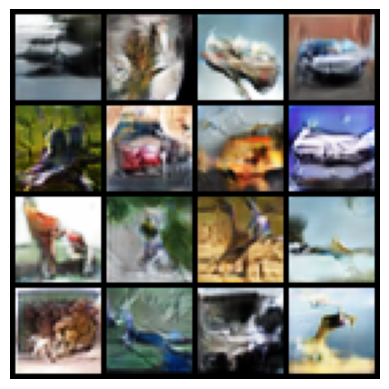

In [35]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       
        real_images = batch[0].to(device) 
       
        valid = torch.ones(real_images.size(0), 1, device=device) # Labels for real
        fake = torch.zeros(real_images.size(0), 1, device=device) # Labels for fake
       
        real_images = real_images.to(device)

        optimizer_D.zero_grad()
       
        z = torch.randn(real_images.size(0), latent_dim, device=device)
      
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
    
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
      
        gen_images = generator(z)
        
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()
       
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()